# Ising Model

## 1. What is Ising model?

Consider a set Λ of lattice sites, each with a set of adjacent sites (e.g. a graph) forming a d-dimensional lattice. For each lattice site k ∈ Λ there is a discrete variable σk such that σk  ∈ {+1, −1}, representing the site's spin. A spin configuration, σ = (σk)k ∈ Λ is an assignment of spin value to each lattice site.

For any two adjacent sites i, j ∈ Λ there is an interaction Jij. Also a site j ∈ Λ has an external magnetic field hj interacting with it. The energy of a configuration σ is given by the Hamiltonian function

$H(\sigma)=-\underset{<i,j>}{\sum}J_{ij}\sigma_i\sigma_j-\mu\underset{j}{\sum}h_j\sigma_j$

where the first sum is over pairs of adjacent spins (every pair is counted once). The notation ⟨ij⟩ indicates that sites i and j are nearest neighbors. The magnetic moment is given by µ.

*from [Wikipedia](https://en.wikipedia.org/wiki/Ising_model)*

## 2. How to build?

Install Python3, Jupyter, pybind11, and a supported C++ compiler. \
Run `./BuildCore.sh` to build `IsingCore` plugin (Tested on Ubuntu 21.04).\
Then import the plugin by executing,

In [2]:
import IsingCore

## 3. What can it do?

This module has two functions: metro and wolff, let's try them out.

In [3]:
IsingCore.metro(128, True, 5, 10000, 10000, 5, 0)

[(260, -6448), (72, -6556), (210, -6512), (342, -6600), (476, -6704)]

In [4]:
IsingCore.wolff(64, False, 3, 100, 100, 4, 1)

[(218, -5016), (-102, -4532), (-108, -4200), (130, -3984)]

They are different Monte Carlo algorithms but with the same input and output.

- Input: `model_size`, `random_init`, `temperature`, `init_flip`, `step_flip`, `steps`, `wid`
- Output: a list of Magnetization-Energy Pair in each thermo-step

More specificly, they are...

### 3.1 The Metropolis Algorithm

(1) Choose an initial micro-state.

(2) Choose a spin at random and flip it. (1/N selection probability)

(3) Compute energy difference $\Delta E=E_i-E_j$

(4) Check if $\Delta E\leq 0$ in this case the trial micro-state is accepted.

(5) If $\Delta E > 0$, compute the ratio of probability $\rho=e^{-\beta \Delta E}$

(6) Choose a uniform random number “r” in the interval [0, 1].

(7) Verify if $r\leq \rho$. In this case the trial micro-state is accepted, otherwise it is rejected.

(8) Repeat steps (2) through (7) until all spins of the system are tested.

(9) Compute the physical quantities of interest in “n” thermalized micro states. This can be done periodically in order to reduce correlation between the data points.

(10)Compute average and variance.

### 3.2 The Wolff algorithm

(1) Choose a seed spin a random from the lattice.

(2) Look in turn at each of the neighbours of that spin. If they are pointing in the same direction as
the seed spin, add them to the cluster with probability $P_{add} = 1-e^{-2\beta J}$

(3) For each spin that was added in the last step, examine each of its neighbors to find the ones
with are pointing in the same direction and add each of them to cluster with the same
probability. This step is recreated as many times as necessary until there are no spins left in the
cluster whose neighbor have not been considered for inclusion in the cluster.

(4) Flip the cluster.

*from the lectures*

## 4. Results

Define some handy functions,

In [110]:
def M(l):
    thesum = 0
    for i in l:
        thesum += i[0]
    return thesum/len(l)

def chi(l,T,n):
    M1 = [i[0] for i in l]
    M2 = [i*i for i in M1]
    ret = [0.0 for i in l]
    for i in range(len(l)):
        ret[i] = (1/T) * n**2 * (M2[i]-M1[i]**2)
    return ret

def Cv(l,T,n):
    E1 = [i[1] for i in l]
    E2 = [i*i for i in E1]
    ret = [0.0 for i in l]
    for i in range(len(l)):
        ret[i] = (1/T)**2 * n**(-2) * (E2[i]-E1[i]**2)
    return ret

### 4.0 {32x32 64x64 128x128} $\bigotimes$ {metro wolff} $\bigotimes$ {$M$ $\chi$ $C_v$} $\bigoplus$ {48x48 96x96} $\bigotimes$ {wolff} $\bigotimes$ {$M$ $\chi$}

Calculate required data.

In [84]:
def m3(x):
    return IsingCore.metro(32, True, x[0], 20000, 10000, 100, x[1])
def m6(x):
    return IsingCore.metro(64, True, x[0], 200000, 100000, 100, x[1])
def m1(x):
    return IsingCore.metro(128, True, x[0], 2000000, 1000000, 100, x[1])
def w3(x):
    return IsingCore.wolff(32, True, x[0], 10000, 1000, 100, x[1])
def w4(x):
    return IsingCore.wolff(48, True, x[0], 3000, 3000, 100, x[1])
def w6(x):
    return IsingCore.wolff(64, True, x[0], 100000, 10000, 100, x[1])
def w9(x):
    return IsingCore.wolff(96, True, x[0], 300000, 30000, 100, x[1])
def w1(x):
    return IsingCore.wolff(128, True, x[0], 100000, 10000, 100, x[1])

In [145]:
import numpy as np
ctr = 0
tasks = []
for t in np.linspace(1.7,2.7,100):
    tasks += [(t,ctr)]
    ctr += 1
t = np.linspace(1.7,2.7,100)

from multiprocessing import Pool
data = []
with Pool(15) as p:
    data = p.map(m6, tasks)

In [146]:
lM = []
lc = []
lC = []
for i in range(len(data)):
    lM.append(M(data[i]))
    lc.append(chi(data[i],t[i],32))
    lC.append(Cv(data[i],t[i],32))

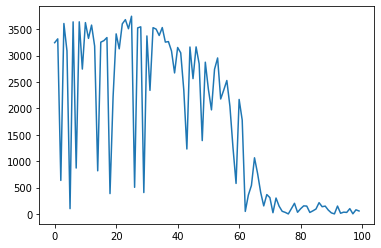

In [147]:
plt.plot([abs(i) for i in lM])

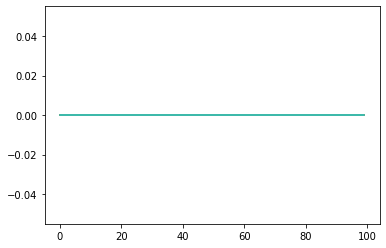

In [124]:
import matplotlib.pyplot as plt
plt.plot(lc)

### 4.1 {32x32 64x64 128x128} $\bigotimes$ {metro wolff} $\bigotimes$ {$M$ $\chi$ $C_v$}

### 4.2 {128x128} $\bigotimes$ {wolff} $\bigotimes$ {$M$ $\chi$}

### 4.3 {32x32 48x48 64x64 96x96 128x128} $\bigotimes$ {wolff} $\bigotimes$ {$M$ $\chi$} $\bigotimes$ {$T_c$ $\nu$ $\beta$ $gamma$}